In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
from pathlib import Path
import shutil
import random
from skimage.io import imread
from PIL import Image

# Tensorflow and Keras
import tensorflow as tf
import tensorflow_addons as tfa
  # Image processing
from keras.utils import img_to_array, load_img
from keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomTranslation, RandomRotation, RandomContrast
  # Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow_addons.metrics import F1Score
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

### Defining paths

In [3]:
train_dir = Path('images_split/Training')
val_dir = Path('images_split/Validation')
test_dir = Path('images_split/Test')

### Image Generators

In [4]:
img_width, img_height = 256, 256
batch_size = 64

train_generator = image_dataset_from_directory(
    train_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical')

val_generator = image_dataset_from_directory(
    val_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False)

test_generator = image_dataset_from_directory(
    test_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False)

Found 11596 files belonging to 114 classes.
Found 2485 files belonging to 114 classes.
Found 2486 files belonging to 114 classes.


# Baseline Model

In [6]:
model = Sequential([])

model.add(Input(shape=(256,256,3)))

model.add(Rescaling(1./255))
model.add(RandomFlip(mode='horizontal_and_vertical'))
model.add(RandomContrast(0.3))
model.add(RandomTranslation(0.1, 0.2))
model.add(RandomRotation(0.2))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(114, activation='softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_contrast_1 (RandomCo  (None, 256, 256, 3)      0         
 ntrast)                                                         
                                                                 
 random_translation_1 (Rando  (None, 256, 256, 3)      0         
 mTranslation)                                                   
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                      

In [8]:
# Compile
opt_adam = Adam(learning_rate=0.001)
f1 = F1Score(num_classes=114, average='weighted')

model.compile(optimizer=opt_adam, loss='categorical_crossentropy', metrics=['accuracy',f1])

In [9]:
# ModelCheckpoint callback - save best weights
chekpoint = ModelCheckpoint(filepath='new_simple_model.weights.best.hdf5',
                            save_best_only=True,
                            verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [25]:
# Train
history = model.fit(train_generator,
                    epochs=200,
                    validation_data=val_generator,
                    callbacks=[chekpoint, early_stop])

Epoch 1/200
182/182 [==============================] - ETA: 0s - loss: 4.5626 - accuracy: 0.0339 - f1_score: 0.0088
Epoch 1: val_loss improved from inf to 4.51616, saving model to new_simple_model.weights.best.hdf5
182/182 [==============================] - 187s 956ms/step - loss: 4.5626 - accuracy: 0.0339 - f1_score: 0.0088 - val_loss: 4.5162 - val_accuracy: 0.0350 - val_f1_score: 0.0024
Epoch 2/200
182/182 [==============================] - ETA: 0s - loss: 4.5221 - accuracy: 0.0365 - f1_score: 0.0067
Epoch 2: val_loss improved from 4.51616 to 4.51575, saving model to new_simple_model.weights.best.hdf5
182/182 [==============================] - 171s 936ms/step - loss: 4.5221 - accuracy: 0.0365 - f1_score: 0.0067 - val_loss: 4.5157 - val_accuracy: 0.0374 - val_f1_score: 0.0054
Epoch 3/200
182/182 [==============================] - ETA: 0s - loss: 4.5193 - accuracy: 0.0369 - f1_score: 0.0058
Epoch 3: val_loss did not improve from 4.51575
182/182 [==============================] - 171s 9

In [26]:
# Evaluation
model.load_weights('new_simple_model.weights.best.hdf5')
loss, accuracy, f1 = model.evaluate(test_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test F1 Score:", f1)

39/39 [==============================] - 3s 76ms/step - loss: 3.5125 - accuracy: 0.2088 - f1_score: 0.1894
Test Loss: 3.5124573707580566
Test Accuracy: 0.20876911282539368
Test F1 Score: 0.18941441178321838


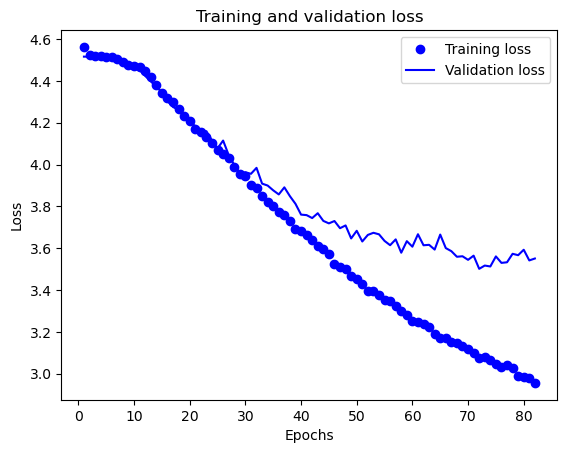

In [27]:
# Loss visualiztion
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()